# NEURAL NETWORKS AND DEEP LEARNING

---
Scaramuzza Luca 2019132 - Homework 1
---


# Set up the environment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import itertools

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [5]:
torch.manual_seed(0)

# Import Dataset

In [6]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



In [7]:
class ImageDataset(Dataset):

    def __init__(self, dataset, transform=None):
        self.transform = transform
        self.data = []
        to_tensor = torchvision.transforms.ToTensor()
        for d in dataset:
          image = d[0]
          label = d[1]
          image = to_tensor(image)
          label = torch.tensor(label).long()
          self.data.append((image, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [8]:
class ImageToVector():
  def __call__(self, sample):
    image = sample[0]
    image = torch.reshape(image, (-1,))
    return (image, sample[1])

In [9]:
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [int(0.8*len(train_dataset)),int(0.2*len(train_dataset))])
print('Train samples:', len(train_dataset), '\nValidation samples:', len(valid_dataset), '\nTest samples:', len(test_dataset))

composed_transform=transforms.Compose([ImageToVector()])

train_load= ImageDataset(train_dataset, transform=composed_transform)
valid_load= ImageDataset(valid_dataset, transform=composed_transform)
test_load= ImageDataset(test_dataset, transform=composed_transform)

train_dataset_loader = DataLoader(train_load, batch_size = 128, shuffle=True)
val_dataset_loader = DataLoader(valid_load, batch_size = 128, shuffle=True)
test_dataset_loader = DataLoader(test_load, batch_size = len(test_dataset), shuffle=False)

Train samples: 48000 
Validation samples: 12000 
Test samples: 10000


# Simple Classifier model

## Model definition

In [22]:
class SimpleClas(nn.Module):
    
    def __init__(self, input, hidden1, hidden2, out, drop):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input, out_features=hidden1)
        self.fc2 = nn.Linear(in_features=hidden1, out_features=hidden2)
        self.out = nn.Linear(in_features=hidden2, out_features=out)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=drop)
        
    def forward(self, x, additional_out=False):
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

## Simple classifier training with initial parameters

In [23]:
def training_cycle(net, loss_function, optimizer, num_epochs, train_dataloader, val_dataloader, verbose=True):
    print(net)
    sigmoid = nn.Sigmoid()
    train_accuracy_log = []
    val_accuracy_log = []
    train_loss_log = []
    val_loss_log = []
    for epoch_num in range(num_epochs):
        if verbose:
          print('EPOCH %d/%d' % (epoch_num + 1, num_epochs))

        ### TRAIN
        train_pred = []
        train_loss = []
        net.train() # Training mode
        for sample_batched in train_dataloader:
            x_train = sample_batched[0].to(device)
            labels_train = sample_batched[1].to(device)
            out = net(x_train)
            loss = loss_function(out, labels_train)
            net.zero_grad()
            loss.backward()
            optimizer.step()
            predictions = torch.argmax(sigmoid(out), dim=1)
            train_predicted = (predictions == labels_train).int().sum().item() / x_train.shape[0]
            train_pred.append(train_predicted)
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        train_pred = np.mean(train_pred)
        train_loss = np.mean(train_loss)
        if verbose:
            print(f"AVERAGE TRAIN ACCURACY: {train_pred * 100}%")
            print(f"AVERAGE TRAIN LOSS: {train_loss}")
        train_accuracy_log.append(train_pred)
        train_loss_log.append(train_loss)

        ### VALIDATION
        val_pred = []
        val_loss = []
        net.eval()
        with torch.no_grad():
            for sample_batched in val_dataloader:
                x_val = sample_batched[0].to(device)
                labels_val = sample_batched[1].to(device)
                output = net(x_val)
                loss = loss_function(output, labels_val)
                prediction = torch.argmax(sigmoid(output), dim=1)
                val_predicted = (prediction == labels_val).int().sum().item() / x_val.shape[0]
                val_pred.append(val_predicted)
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
            val_pred = np.mean(val_pred)
            val_loss = np.mean(val_loss)
            if verbose:
                print(f"AVERAGE VAL ACCURACY: {val_pred * 100}%")
                print(f"AVERAGE VAL LOSS: {val_loss}")
            val_accuracy_log.append(val_pred)
            val_loss_log.append(val_loss)
    return train_accuracy_log, val_accuracy_log, train_loss_log, val_loss_log

In [25]:
input = 784
output = 10
hidden1 = 256
hidden2 = 256
drop = 0.3
lr = 0.001
max_epochs = 100
loss_function = nn.CrossEntropyLoss()

net = SimpleClas(input, hidden1, hidden2, output, drop)
optimizer = optim.Adam(net.parameters(), lr=lr)
train_accuracy_log, val_accuracy_log, train_loss_log, val_loss_log = training_cycle(net, loss_function, optimizer, max_epochs, train_dataset_loader, val_dataset_loader, verbose=True)

print("\nTrain Accuracy: %f" %(np.mean(train_accuracy_log)))
print("Train Loss: %f" %(np.mean(train_loss_log)))

print("\nValidation Accuracy: %f" %(np.mean(val_accuracy_log)))
print("Validation Loss: %f" %(np.mean(val_loss_log)))

SimpleClas(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
EPOCH 1/100
AVERAGE TRAIN ACCURACY: 76.90208333333334%
AVERAGE TRAIN LOSS: 0.6409211754798889
AVERAGE VAL ACCURACY: 84.63264627659575%
AVERAGE VAL LOSS: 0.41839420795440674
EPOCH 2/100
AVERAGE TRAIN ACCURACY: 84.3375%
AVERAGE TRAIN LOSS: 0.4333271086215973
AVERAGE VAL ACCURACY: 85.23936170212765%
AVERAGE VAL LOSS: 0.3865787386894226
EPOCH 3/100
AVERAGE TRAIN ACCURACY: 85.95208333333333%
AVERAGE TRAIN LOSS: 0.39252468943595886
AVERAGE VAL ACCURACY: 86.47495567375886%
AVERAGE VAL LOSS: 0.3597865402698517
EPOCH 4/100
AVERAGE TRAIN ACCURACY: 86.54375%
AVERAGE TRAIN LOSS: 0.36971232295036316
AVERAGE VAL ACCURACY: 86.94869237588651%
AVERAGE VAL LOSS: 0.348595529794693
EPOCH 5/100
AVERAGE TRAIN ACCURACY: 87.2625%
AVERAGE TRAIN LOSS: 0.3473

## Plot losses and accuracy

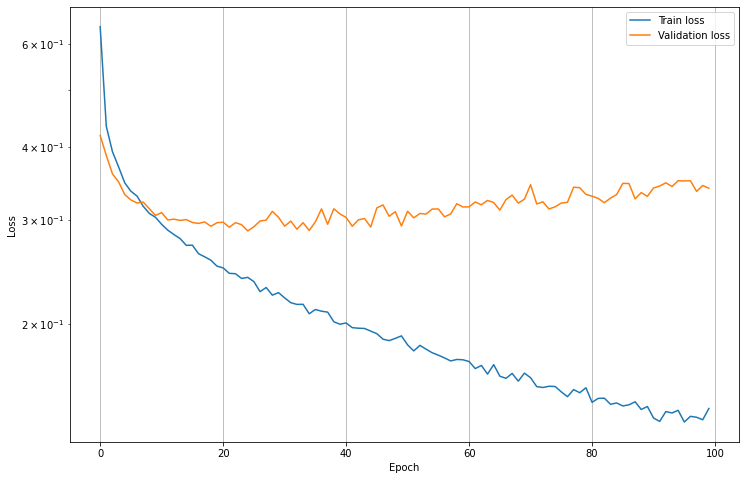

In [26]:
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Grid search

In [13]:
input = 784
output = 10
hidden1 = [32, 64, 128, 256]
hidden2 = [32, 64, 128]
drop = [0, 0.3, 0.5]
lr = [0.01, 0.001]
max_epochs = [50]
loss_function = nn.CrossEntropyLoss()

it=[]
hyperparameters = [hidden1, hidden2, drop, lr, max_epochs]

for i in itertools.product(*hyperparameters):
    it.append(i)
print("Total Combinations:",len(it))

best_hyper = None
best_acc = None

for i,h in enumerate(it):
    print("\nIteration: ",i,h)
    hidden1, hidden2, drop, lr, max_epochs = h
    net = SimpleClas(input, hidden1, hidden2, output, drop)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    epoch = max_epochs
    train_accuracy_log, val_accuracy_log, train_loss_log, val_loss_log = training_cycle(net, loss_function, optimizer, epoch, train_dataset_loader, val_dataset_loader, verbose=True)
    mean_acc = np.mean(val_accuracy_log)
    if not best_acc or mean_acc>best_acc:
        best_acc = mean_acc
        best_hyper = h
print("Best hyperparameters ",best_hyper)

Output streaming troncato alle ultime 5000 righe.
AVERAGE TRAIN LOSS: 0.7191075682640076
AVERAGE VAL ACCURACY: 68.46187943262412%
AVERAGE VAL LOSS: 0.5328993797302246
EPOCH 36/50
AVERAGE TRAIN ACCURACY: 61.20833333333333%
AVERAGE TRAIN LOSS: 0.7151502966880798
AVERAGE VAL ACCURACY: 69.48415336879434%
AVERAGE VAL LOSS: 0.5527369379997253
EPOCH 37/50
AVERAGE TRAIN ACCURACY: 62.09583333333333%
AVERAGE TRAIN LOSS: 0.7224546074867249
AVERAGE VAL ACCURACY: 75.77847960992908%
AVERAGE VAL LOSS: 0.5191482901573181
EPOCH 38/50
AVERAGE TRAIN ACCURACY: 63.48541666666667%
AVERAGE TRAIN LOSS: 0.7288268208503723
AVERAGE VAL ACCURACY: 69.09906914893617%
AVERAGE VAL LOSS: 0.5176336169242859
EPOCH 39/50
AVERAGE TRAIN ACCURACY: 61.44166666666667%
AVERAGE TRAIN LOSS: 0.7276588678359985
AVERAGE VAL ACCURACY: 66.5586214539007%
AVERAGE VAL LOSS: 0.5298196077346802
EPOCH 40/50
AVERAGE TRAIN ACCURACY: 59.650000000000006%
AVERAGE TRAIN LOSS: 0.7212949395179749
AVERAGE VAL ACCURACY: 69.05474290780141%
AVERAGE VA

## Simple classifier training with parameters found with grid search

In [27]:
#hidden1, hidden2, drop, lr, max_epochs = best_hyper
hidden1, hidden2, drop, lr, max_epochs = [256, 128, 0.3, 0.001, 50]
net = SimpleClas(input, hidden1, hidden2, output, drop)
optimizer = optim.Adam(net.parameters(), lr=lr)
epochs = max_epochs

train_accuracy_log, val_accuracy_log, train_loss_log, val_loss_log = training_cycle(net, loss_function, optimizer, epochs, train_dataset_loader, val_dataset_loader, verbose=True)

print("\nTrain Accuracy: %f" %(np.mean(train_accuracy_log)))
print("Train Loss: %f" %(np.mean(train_loss_log)))

print("\nValidation Accuracy: %f" %(np.mean(val_accuracy_log)))
print("Validation Loss: %f" %(np.mean(val_loss_log)))

SimpleClas(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
EPOCH 1/50
AVERAGE TRAIN ACCURACY: 75.44791666666667%
AVERAGE TRAIN LOSS: 0.6780946254730225
AVERAGE VAL ACCURACY: 82.89561170212765%
AVERAGE VAL LOSS: 0.45666584372520447
EPOCH 2/50
AVERAGE TRAIN ACCURACY: 84.08333333333333%
AVERAGE TRAIN LOSS: 0.4444279670715332
AVERAGE VAL ACCURACY: 84.93184840425532%
AVERAGE VAL LOSS: 0.3978540897369385
EPOCH 3/50
AVERAGE TRAIN ACCURACY: 85.53958333333334%
AVERAGE TRAIN LOSS: 0.4024066627025604
AVERAGE VAL ACCURACY: 86.00675975177306%
AVERAGE VAL LOSS: 0.3691018223762512
EPOCH 4/50
AVERAGE TRAIN ACCURACY: 86.45%
AVERAGE TRAIN LOSS: 0.3765048384666443
AVERAGE VAL ACCURACY: 86.68550531914893%
AVERAGE VAL LOSS: 0.3550548851490021
EPOCH 5/50
AVERAGE TRAIN ACCURACY: 86.91666666666666%
AVERAGE TRAIN L

## Plot losses and accuracy

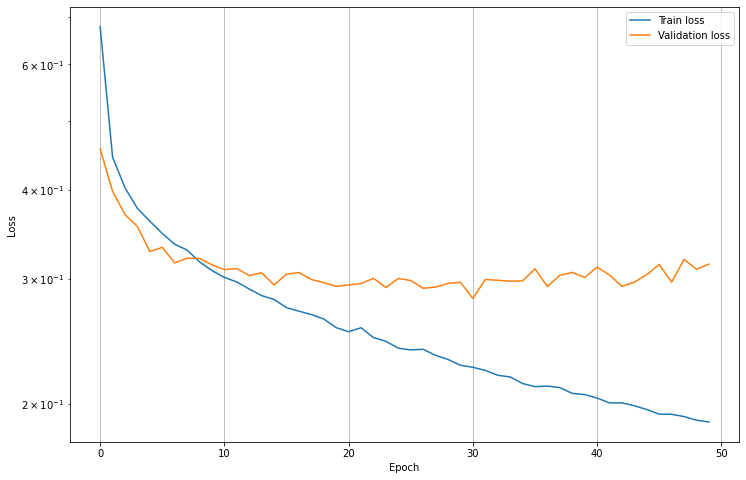

In [28]:
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Test evaluation

In [29]:
test_predictions = []
sigmoid = nn.Sigmoid()
net.eval()
with torch.no_grad():
    for sample_batched in test_dataset_loader: 
      x_test = sample_batched[0].to(device)
      labels_test = sample_batched[1].to(device)
      output = net(x_test)
      prediction = torch.argmax(sigmoid(output), dim=1)
      correct_predictions = (prediction == labels_test).int().sum().item() / x_test.shape[0]
      test_predictions.append(correct_predictions)
    test_predictions = np.mean(test_predictions)
    print(f"AVERAGE ACCURACY: {test_predictions * 100}%")

AVERAGE ACCURACY: 89.16%


# Simple CNN model

## Model definition

In [11]:
class SimpleConv(nn.Module):
    
    def __init__(self, conv1_dim=32,conv2_dim=64,fc_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, conv1_dim, kernel_size=3)
        self.conv2 = nn.Conv2d(conv1_dim, conv2_dim, kernel_size=3)
        flat_dim = conv2_dim*24*24
        self.fc = nn.Linear(flat_dim, fc_dim)
        self.out = nn.Linear(fc_dim, 10)
        self.act = nn.ReLU()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.act(self.fc(x))
        x = self.out(x)
        return x

## Simple CNN training with initial parameters

In [12]:
netConv = SimpleConv()
netConv = netConv.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(netConv.parameters(), lr=0.001)
num_epochs=10
print(netConv)

SimpleConv(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=36864, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
  (act): ReLU()
)


In [13]:
basic_transf = transforms.Compose( [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,)),
                                    ] )

train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=basic_transf)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=basic_transf)

trainloader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size = 64, shuffle=True)

In [15]:
sigmoid = nn.Sigmoid()
train_accuracy_log = []
train_loss_log = []
for epoch_num in range(num_epochs):
    print('EPOCH %d/%d' % (epoch_num + 1, num_epochs))
    train_pred = []
    train_loss = []
    netConv.train()
    for sample_batched in trainloader:
        x_train = sample_batched[0].to(device)
        labels_train = sample_batched[1].to(device)
        out = netConv(x_train)
        loss = loss_function(out, labels_train)
        netConv.zero_grad()
        loss.backward()
        optimizer.step()
        predictions = torch.argmax(sigmoid(out), dim=1)
        train_predicted = (predictions == labels_train).int().sum().item() / x_train.shape[0]
        train_pred.append(train_predicted)
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    train_pred = np.mean(train_pred)
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN ACCURACY: {train_pred * 100}%")
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_accuracy_log.append(train_pred)
    train_loss_log.append(train_loss)

EPOCH 1/10
AVERAGE TRAIN ACCURACY: 86.07575959488273%
AVERAGE TRAIN LOSS: 0.38868799805641174
EPOCH 2/10
AVERAGE TRAIN ACCURACY: 91.6028118336887%
AVERAGE TRAIN LOSS: 0.2277282178401947
EPOCH 3/10
AVERAGE TRAIN ACCURACY: 94.24806769722814%
AVERAGE TRAIN LOSS: 0.15757402777671814
EPOCH 4/10
AVERAGE TRAIN ACCURACY: 96.2669909381663%
AVERAGE TRAIN LOSS: 0.10431469976902008
EPOCH 5/10
AVERAGE TRAIN ACCURACY: 97.57129530916845%
AVERAGE TRAIN LOSS: 0.06689444184303284
EPOCH 6/10
AVERAGE TRAIN ACCURACY: 98.40418443496802%
AVERAGE TRAIN LOSS: 0.04457242786884308
EPOCH 7/10
AVERAGE TRAIN ACCURACY: 98.95722281449893%
AVERAGE TRAIN LOSS: 0.03004453144967556
EPOCH 8/10
AVERAGE TRAIN ACCURACY: 99.22374733475479%
AVERAGE TRAIN LOSS: 0.021888619288802147
EPOCH 9/10
AVERAGE TRAIN ACCURACY: 99.34368336886993%
AVERAGE TRAIN LOSS: 0.019258860498666763
EPOCH 10/10
AVERAGE TRAIN ACCURACY: 99.4069829424307%
AVERAGE TRAIN LOSS: 0.016439758241176605


## Plot losses and accuracy

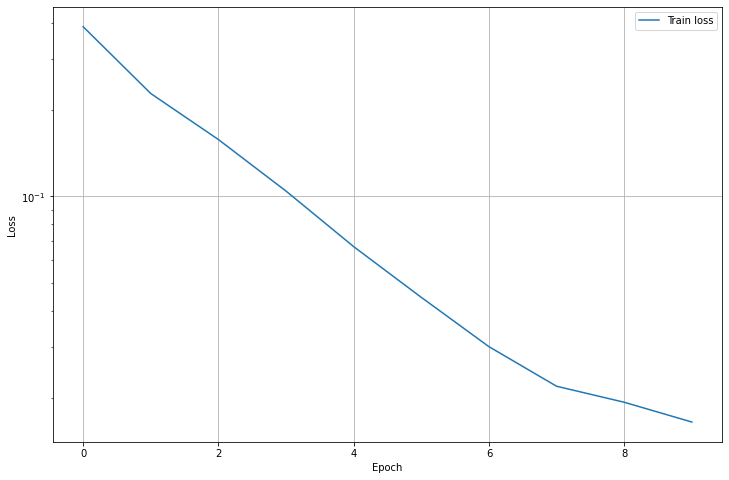

In [17]:
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

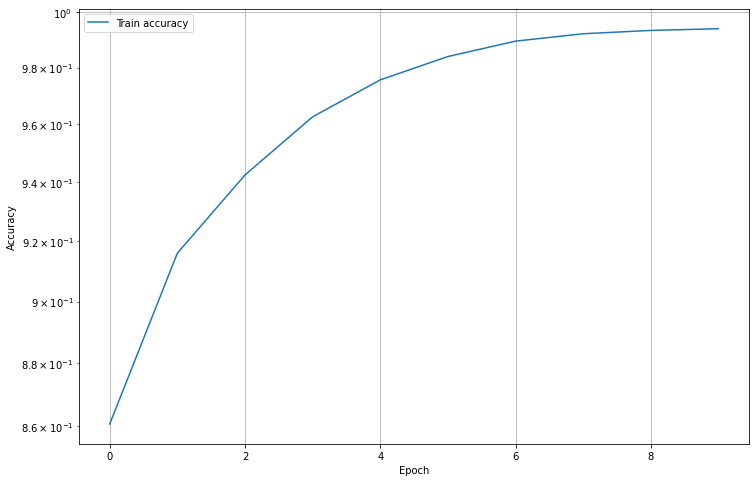

In [18]:
plt.figure(figsize=(12,8))
plt.semilogy(train_accuracy_log, label='Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

In [19]:
test_predictions = []
sigmoid = nn.Sigmoid()
netConv.eval()
with torch.no_grad():
    for sample_batched in testloader: 
        x_test = sample_batched[0].to(device)
        labels_test = sample_batched[1].to(device)
        output = netConv(x_test)
        prediction = torch.argmax(sigmoid(output), dim=1)
        correct_predictions = (prediction == labels_test).int().sum().item() / x_test.shape[0]
        test_predictions.append(correct_predictions)
    test_predictions = np.mean(test_predictions)
    print(f"AVERAGE ACCURACY: {test_predictions * 100}%")

AVERAGE ACCURACY: 91.22213375796179%


# Models analysis

## Simple classifier

Weight histogram

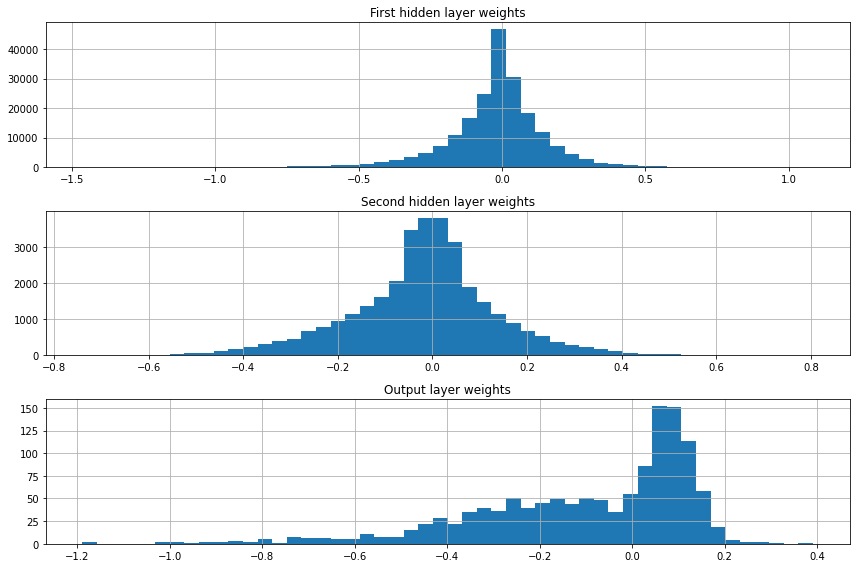

In [36]:
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

Activation profiles

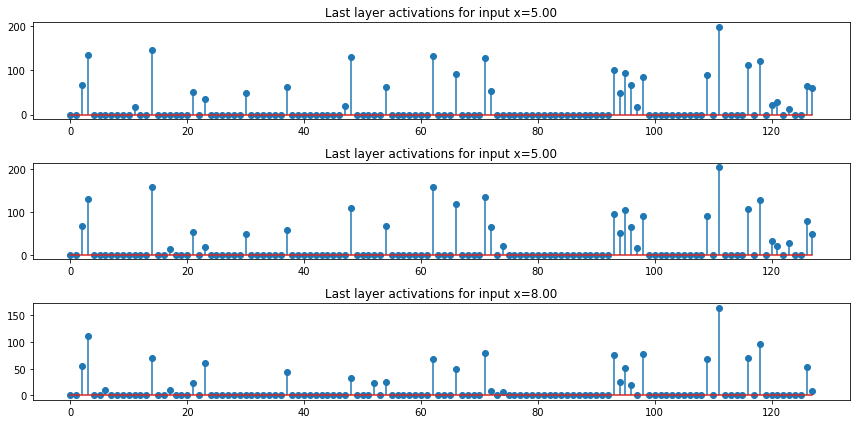

In [37]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

hook_handle = net.fc2.register_forward_hook(get_activation)

net = net.to(device)
net.eval()
sub_load = DataLoader(test_dataset, batch_size=3, shuffle=True, num_workers=0)
for batch in sub_load:
  images = batch[0]
  labels = batch[1]
  x1 = images[0]
  label1 = labels[0]
  x1 = x1.unsqueeze(0).to(device)
  x2 = images[1]
  label2 = labels[1]
  x2 = x2.unsqueeze(0).to(device)
  x3 = images[2]
  label3 = labels[2]
  x3 = x3.unsqueeze(0).to(device)
  break

with torch.no_grad():
    y1 = net(x1)
    z1 = activation
    y2 = net(x2)
    z2 = activation
    y3 = net(x3)
    z3 = activation

hook_handle.remove()

fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % label1)
axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % label2)
axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % label3)
plt.tight_layout()
plt.show()

Receptive fields for the simple classifier

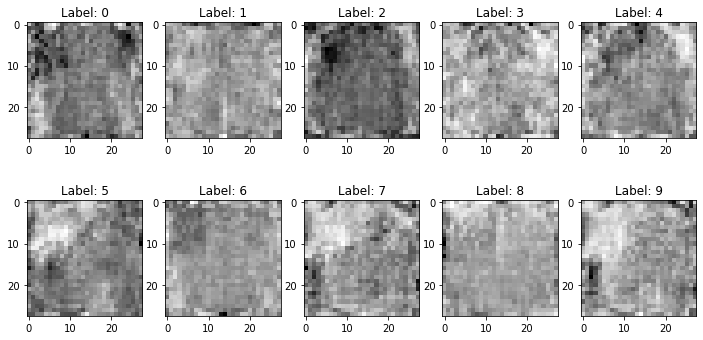

In [32]:
fig, axs = plt.subplots(2, 5, figsize=(12,6))
for i in range(5):
    rec = np.matmul(out_w[i],np.matmul(h2_w,h1_w))
    axs[0][i].imshow(rec.reshape(784).reshape(28,28),cmap='Greys')
    axs[0][i].set_title("Label: "+str(i))  
for i in range(5,10):
    rec = np.matmul(out_w[i],np.matmul(h2_w,h1_w))
    axs[1][i-5].imshow(rec.reshape(784).reshape(28,28),cmap='Greys')
    axs[1][i-5].set_title("Label: "+str(i))
plt.show()

## Simple CNN

Weight histogram

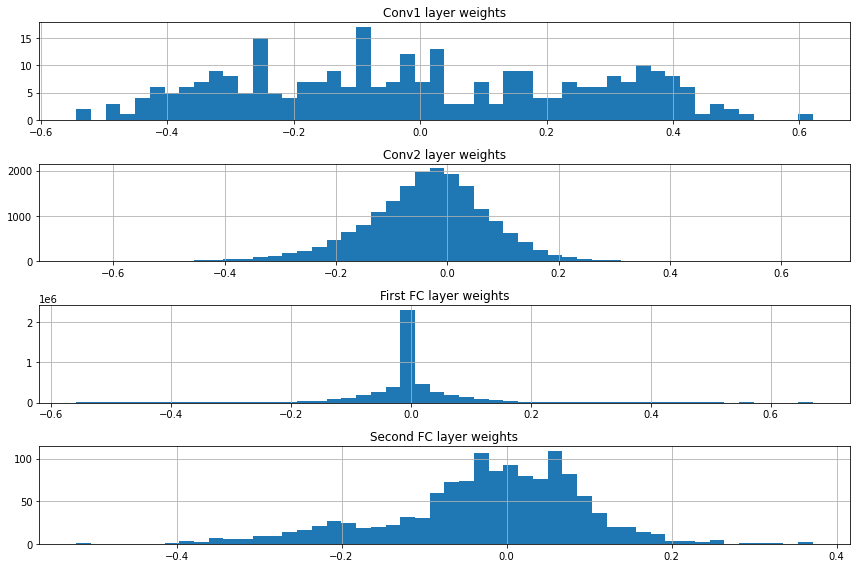

In [34]:
c1_w = netConv.conv1.weight.data.cpu().numpy()
c1_b = netConv.conv1.bias.data.cpu().numpy()

c2_w = netConv.conv2.weight.data.cpu().numpy()
c2_b = netConv.conv2.bias.data.cpu().numpy()

h1_w = netConv.fc.weight.data.cpu().numpy()
h1_b = netConv.fc.bias.data.cpu().numpy()

h2_w = netConv.out.weight.data.cpu().numpy()
h2_b = netConv.out.bias.data.cpu().numpy()

fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(c1_w.flatten(), 50)
axs[0].set_title('Conv1 layer weights')
axs[1].hist(c2_w.flatten(), 50)
axs[1].set_title('Conv2 layer weights')
axs[2].hist(h1_w.flatten(), 50)
axs[2].set_title('First FC layer weights')
axs[3].hist(h2_w.flatten(), 50)
axs[3].set_title('Second FC layer weights')

[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

Activation profiles for the simple classifier

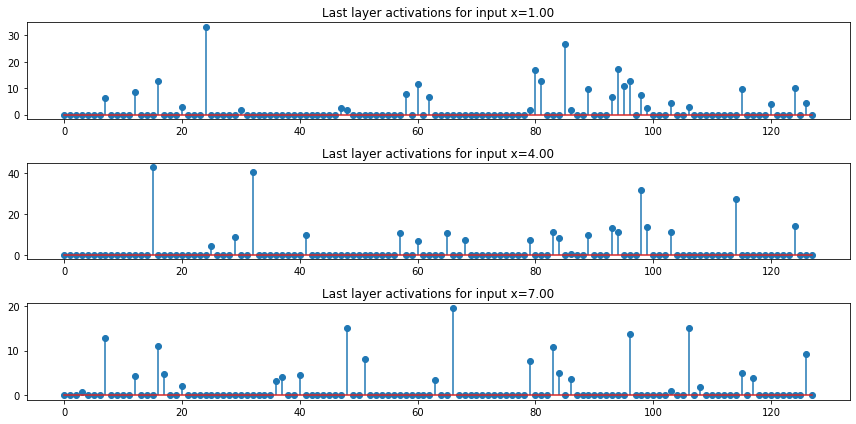

In [35]:
hook_handle = netConv.fc.register_forward_hook(get_activation)

netConv = netConv.to(device)
netConv.eval()
sub_load = DataLoader(test_dataset, batch_size=3, shuffle=True, num_workers=0)
for batch in sub_load:
  images = batch[0]
  labels = batch[1]
  x1 = images[0]
  label1 = labels[0]
  x1 = x1.unsqueeze(0).to(device)
  x2 = images[1]
  label2 = labels[1]
  x2 = x2.unsqueeze(0).to(device)
  x3 = images[2]
  label3 = labels[2]
  x3 = x3.unsqueeze(0).to(device)
  break

with torch.no_grad():
    y1 = netConv(x1)
    z1 = activation
    y2 = netConv(x2)
    z2 = activation
    y3 = netConv(x3)
    z3 = activation

hook_handle.remove()

fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % label1)
axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % label2)
axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % label3)
plt.tight_layout()
plt.show()